Copyright (c) 2017, Hiori Kino

All rights reserved.

This software is released under the BSD License (3-clause BSD License). 

#### descriptorの作成方法2.

# read xsf and generate descriptors for clustering 


use multiidnex dataframe to express
data(crystal id, atom id, descriptors)

# 1. data preparation

structure search of eight carbon atoms with periodic GRRM

Makito Takagi, Tetsuya Taketsugu, Hiori Kino, Yoshitaka Tateyama, Kiyoyuki Terakura, and Satoshi Maeda,
"Global search for low-lying crystal structures using the artificial force induced reaction method: A case study on carbon",
Phys. Rev. B 95, 184110, (2017)

There exist structure, total energy data in the supplement. 
I changed them to the xsf format and stored them in the Maeda_carbon8_xsf/ directory

## geometry
in the case of sieta PBE+D2, graphite structure is 

* the nearest neighbour distance is 1.4 Ang along the ab-plane.
* the interlayer distance along the c direction is 3.4Ang


I used the cutoff 3.0Ang. 


## Reference


### descriptor 
1. Jörg Behler and Michele Parrinello, "Generalized Neural-Network Representation of High-Dimensional Potential-Energy Surfaces", Phys. Rev. Lett. 98, 146401(2007) 


### pymatgen
1. Shyue Ping Ong, William Davidson Richards, Anubhav Jain, Geoffroy Hautier, Michael Kocher, Shreyas Cholia, Dan Gunter, Vincent Chevrier, Kristin A. Persson, Gerbrand Ceder. "Python Materials Genomics (pymatgen) : A Robust, Open-Source Python Library for Materials Analysis". Computational Materials Science, 2013, 68, 314–319. 


## Reference


### descriptor 
1. Jörg Behler and Michele Parrinello, "Generalized Neural-Network Representation of High-Dimensional Potential-Energy Surfaces", Phys. Rev. Lett. 98, 146401(2007) 


### pymatgen
1. Shyue Ping Ong, William Davidson Richards, Anubhav Jain, Geoffroy Hautier, Michael Kocher, Shreyas Cholia, Dan Gunter, Vincent Chevrier, Kristin A. Persson, Gerbrand Ceder. "Python Materials Genomics (pymatgen) : A Robust, Open-Source Python Library for Materials Analysis". Computational Materials Science, 2013, 68, 314–319. 


This script executes

1. read crystal structure in the xsf format.
1. change them to the descriptor with Behler's symmetry functions.
1. show pairplot and confirm that they are not linearly dependent. 


# comment 

This script use makesymfun2()

In [1]:
## 2. data preprocessing

In [2]:
from __future__ import print_function

import os
import numpy as np

have_pymatgen = True
try:
    import pymatgen.io.xcrysden
except:
    have_pymatgen = False
if have_pymatgen:
    import pymatgen.core.structure
print("have_pymatgen",have_pymatgen)

import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd
import seaborn as sns

import sklearn.preprocessing
import pickle

import glob

have_pymatgen True


plot shape of symmetry functions


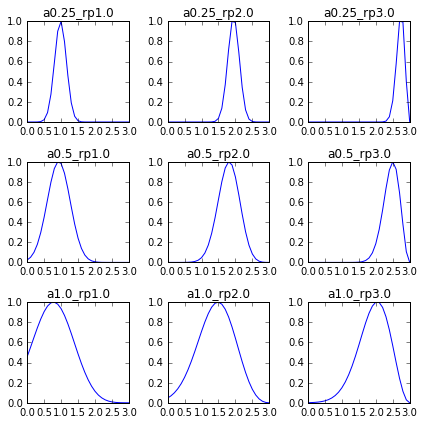

len= 9 , param= {'rc': 3, 'gauss2': {'a': array([ 0.25,  0.25,  0.25,  0.5 ,  0.5 ,  0.5 ,  1.  ,  1.  ,  1.  ]), 'rp': array([ 1.,  2.,  3.,  1.,  2.,  3.,  1.,  2.,  3.]), 'list': {'a': [0.25, 0.5, 1.0], 'rp': array([ 1.,  2.,  3.])}, 'labels': ['a0.25_rp1.0', 'a0.25_rp2.0', 'a0.25_rp3.0', 'a0.5_rp1.0', 'a0.5_rp2.0', 'a0.5_rp3.0', 'a1.0_rp1.0', 'a1.0_rp2.0', 'a1.0_rp3.0']}}


In [3]:
def makesymfun1():
    """
    tyme 1 of the symmetry function parameter
    
    @return : dict 
    """
    eps = 1e-5
    xmax = 3 # = rc in Ang. 
    alist = [ 0.25, 0.5, 1.0] #, 3.0]
    rplist = np.arange(1.0,xmax+eps, 1) 
    rpmesh,amesh = make_mesh(rplist,alist)
    symfunparam = {}
    symfunparam["gauss2"]= {}
    symfunparam["gauss2"]["a"]= amesh
    symfunparam["gauss2"]["rp"]= rpmesh
    symfunparam["gauss2"]["list"] = {}
    symfunparam["gauss2"]["list"]["a"] = alist
    symfunparam["gauss2"]["list"]["rp"] = rplist
       
    labels = []
    label_str = ["a","rp"]
    for a,rp in zip(amesh,rpmesh):
        v = [a,rp]
        value_str = list(map(str,v))
        ss = [label_str[0],value_str[0],"_",label_str[1],value_str[1]]        
        labels.append("".join(ss))
    symfunparam["gauss2"]["labels"] = labels
    symfunparam["rc"] = xmax
    return symfunparam

def makesymfun2():
    """
    type 2 of the symmetry function parameter
    
    @return :dict
    """
    eps = 1e-5
    xmax = 3
    alist = [ 0.25, 0.5, 1.0] #, 3.0]
    rplist = np.arange(1.5,xmax+eps, 1) 
    rpmesh,amesh = make_mesh(rplist,alist)
    symfunparam = {}
    symfunparam["gauss2"]= {}
    symfunparam["gauss2"]["a"]= amesh
    symfunparam["gauss2"]["rp"]= rpmesh
    symfunparam["gauss2"]["list"] = {}
    symfunparam["gauss2"]["list"]["a"] = alist
    symfunparam["gauss2"]["list"]["rp"] = rplist
       
    labels = []
    label_str = ["a","rp"]
    for a,rp in zip(amesh,rpmesh):
        v = [a,rp]
        value_str = list(map(str,v))
        ss = [label_str[0],value_str[0],"_",label_str[1],value_str[1]]        
        labels.append("".join(ss))
    symfunparam["gauss2"]["labels"] = labels
    symfunparam["rc"] = xmax
    return symfunparam


def makesymfun():
    return makesymfun1()
    ##adopt type 1 now


def make_mesh(alist,blist):
    """
    make 3D grid from alist and blist 
    
    alist = [a1,a2]
    blist = [b1,b2,b3]
    -> 
    ablist[:,0] = [a1,a2,a1,a2,a1,a2]
    ablist[:,1] = [b1,b1,b2,b2,b3,b3]
    
    @param alist: a list of var1
    @param blist: a list of var2
    @return : ablist[:,0:2]
    """
    ablist = np.meshgrid(alist,blist)
    ablist2 = []
    for  a,b in zip(ablist[0].ravel(),ablist[1].ravel()):
        ablist2.append([a,b])
    ablist2 = np.array(ablist2)
    return ablist2[:,0],ablist2[:,1]

def bsym_gauss2(xi,alist,rplist,xmax):
    """
    make two body gaussian terms

    @param xi : a list of x
    @param alist : alist of parameter a
    @param rplist : a list of parameter rp
    @param xmax : r_cut
    @return : symmetry function at xi    
    """
    xi = np.array(xi)
    x2 = (xi[:,None]-rplist[None,:])/alist[None,:]
    xi_ap = np.exp(-x2**2)*(np.cos(np.pi*xi[:,None]/xmax)+1.0)*0.5
    return xi_ap    

def plot_gauss2(symfunparam):
    """
    plot two body gaussian terms
    
    @param symfunparam : dict of two body gaussian function
    """
    amesh = symfunparam["gauss2"]["a"]
    rpmesh = symfunparam["gauss2"]["rp"]
    xmax = symfunparam["rc"]
    alist = symfunparam["gauss2"]["list"]["a"]
    rplist = symfunparam["gauss2"]["list"]["rp"]
    labels = symfunparam["gauss2"]["labels"]
    eps = 1e-5

    x = np.arange(0,xmax+eps,0.1)
    y3 = bsym_gauss2(x,amesh,rpmesh,xmax)
    n = len(amesh)
    scaler = sklearn.preprocessing.MinMaxScaler()
    y4 = scaler.fit_transform(y3)
    plt.figure(figsize=(len(rplist)*2,len(alist)*2),dpi=100)
    for i in range(n):
        plt.subplot(len(alist),len(rplist),i+1)
        plt.plot(x,y4[:,i],label=str(i))
        plt.title(labels[i])
        plt.ylim((0,1.0))
    plt.tight_layout()
    plt.show()

symfunparam = makesymfun()
print("plot shape of symmetry functions")
plot_gauss2(symfunparam) 
print ("len=",len(symfunparam["gauss2"]["labels"]),", param=",symfunparam)

In [4]:
from IPython.core.display import display
import copy
if have_pymatgen:
    def loadxsf(filename):
        """
        read xsf file
        convert it to pymatgen.xcrysden 

        @param : filename 
        """
        with open(filename,"rb") as f:
            data = f.readlines()
        data2 = []
        for x in data:
            data2.append(x.decode("utf-8"))
        data = data2
        xsf = pymatgen.io.xcrysden.XSF( pymatgen.core.structure.Structure)
        return xsf.from_string(u"".join(data))

def filename2key(filename):
    """
    split filepath into base and extention
    
    @param filename : filenpath
    """
    d,f = os.path.split(filename)    
    b,ext = os.path.splitext(f)
    return b

def sitei(st,isite,rcut):
    """
    return distance list and coordinate list centedred at isite with the r_cut cutoff distance
    
    @param st : xsf.structure
    @param isite : integer, site index
    @param rcut : cutoff distance
    @return : a list of distance, a list of their coordinates
    """
    distancelist = []
    coordlist = []
    for neigh in st.get_neighbors(st[isite],rcut):
        distancelist.append(neigh[1])
        coordlist.append(neigh[0].coords)
    return distancelist,coordlist

class make_sum_bsf:
    """
    summation of symmetry function
    """
    def __init__(self,dic):
        """
        gauss2body
        
        @param dic : dict
        """
        self.amesh = dic["gauss2"]["a"]
        self.rpmesh = dic["gauss2"]["rp"]
        # rc
        self.xmax = dic["rc"]
    def transform(self,xi,coords,centersite):
        """
        y_{jp} = sum_i exp(-((x_{ij}-rp)/a_p)**2 *(  cos(pi*x_{ij}/xmax) +1 )
       
        @param xi: list of {r_ij}
        @return : y_p,  a_p is given in __init__(alist)
        """
        xi = np.array(xi)
        xi_ap = bsym_gauss2(xi,self.amesh,self.rpmesh,self.xmax)

        sumi_xi_ap = np.sum(xi_ap,axis=0)

        return sumi_xi_ap
    
class make_rdf:
    def __init__(self,filename,rcut):
        """
        @param filename : filename
        @param ene : energy
        @param rcut : cutoff distance
        """        
        self.filename = filename
        self.key = filename2key(filename)

        xsf = loadxsf(filename)
        st = xsf.structure
        self.st = st
        natom = len(st.sites)
        self.rdf = []
        self.coords = []
        for i in range(natom):
            a_rdf,a_coords = sitei(st,i,rcut)
            self.rdf.append(a_rdf)
            self.coords.append(a_coords)
    def make_symfun3(self,symfunparam):
        """
        @param symfunparam : dict, parameter of symmetry function
        @return : a list of each site of symmetry functions 
        """
        self.symfunparam = symfunparam

        sumrdf = make_sum_bsf(symfunparam)
        dlist = []
        for a_rdf,a_coords,a_st in zip(self.rdf,self.coords,self.st.sites):
            y = sumrdf.transform(a_rdf,a_coords,a_st)
            dlist.append(y)
        self.symfun2 = np.array(dlist)        
        return self.symfun2

   
    
def load_xsf(mask,symfunparam):
    """
    load  xsf files and     make descriptors
        
    @param key : file mask for glob.glob
    @param ene_obj : read_energy object
    @param symfunparam : dict, parameter of symmetry fucntions
    @return : a list of desriptors, a list of energy, a list of property, a list of rdf, for sites
    """
    xmax = symfunparam["rc"]
    path_xsf = "../data/Maeda_carbon8_xsf"

    X = []
    for filename in glob.glob( os.path.join(path_xsf,mask )):
        rdf = make_rdf(filename,xmax)
        desc = rdf.make_symfun3(symfunparam)
        key = rdf.key
        for i,d in enumerate(desc):
            x = [key,i]
            x.extend(d)
            X.append(x)

    X = np.array(X)
    print(X.shape)
    index = ["key","atom"]
    columns = copy.deepcopy(index)
    columns.extend( symfunparam["gauss2"]["labels"] )
    print(columns)
    df = pd.DataFrame(X,columns= columns)
    #display(df)
    df2 = df.sort_values(by=index)
    df3 = df2.set_index(index,drop=True)
    
    return df3

if have_pymatgen:
    df = load_xsf("?D-???.xsf",symfunparam)
    df.to_csv("Maeda_carbon8_descriptor_linearmodel.csv",index=True)
else:
    df = pd.read_csv("Maeda_carbon8_descriptor_linearmodel.csv",index_col=[0,1])



key="3D-000"
print (key)
display(df.loc[key])
# print ("all")
# display(df)

(3560, 11)
['key', 'atom', 'a0.25_rp1.0', 'a0.25_rp2.0', 'a0.25_rp3.0', 'a0.5_rp1.0', 'a0.5_rp2.0', 'a0.5_rp3.0', 'a1.0_rp1.0', 'a1.0_rp2.0', 'a1.0_rp3.0']
3D-000


,a0.25_rp1.0,a0.25_rp2.0,a0.25_rp3.0,a0.5_rp1.0,a0.5_rp2.0,a0.5_rp3.0,a1.0_rp1.0,a1.0_rp2.0,a1.0_rp3.0
atom,,,,,,,,,
0,0.0780385189783,0.019561004357,0.0167647550243,0.752427320835,0.613213584057,0.160524243134,1.37368567741,1.50704116672,0.478509050393
1,0.0780339799629,0.019561584843,0.0167647551452,0.7524147081,0.61321945794,0.160524246466,1.37367653703,1.50704187953,0.478510156246
2,0.0780356092014,0.0195616307955,0.0167647537352,0.752417397118,0.613218511267,0.160524233672,1.37367817344,1.50704154085,0.478509957874
3,0.0780355355706,0.0195616437988,0.0167647492125,0.752417166951,0.613218627376,0.160524252432,1.37367800421,1.50704157187,0.478510005624
4,0.0780305718077,0.019562183274,0.0167647572089,0.752404055535,0.613224610676,0.160524229224,1.37366861503,1.50704234688,0.478511096093
5,0.0780351108231,0.0195616036807,0.0167647573298,0.752416668273,0.613218738544,0.160524225224,1.37367775582,1.50704163491,0.478509989792
6,0.078034592017,0.0195617652653,0.0167647491973,0.752414537567,0.613219852787,0.160524253243,1.37367609747,1.50704171965,0.478510236436
7,0.0780346656478,0.0195617523794,0.0167647537504,0.752414767734,0.613219736923,0.160524234395,1.37367626675,1.50704168876,0.478510188641


making pairplot


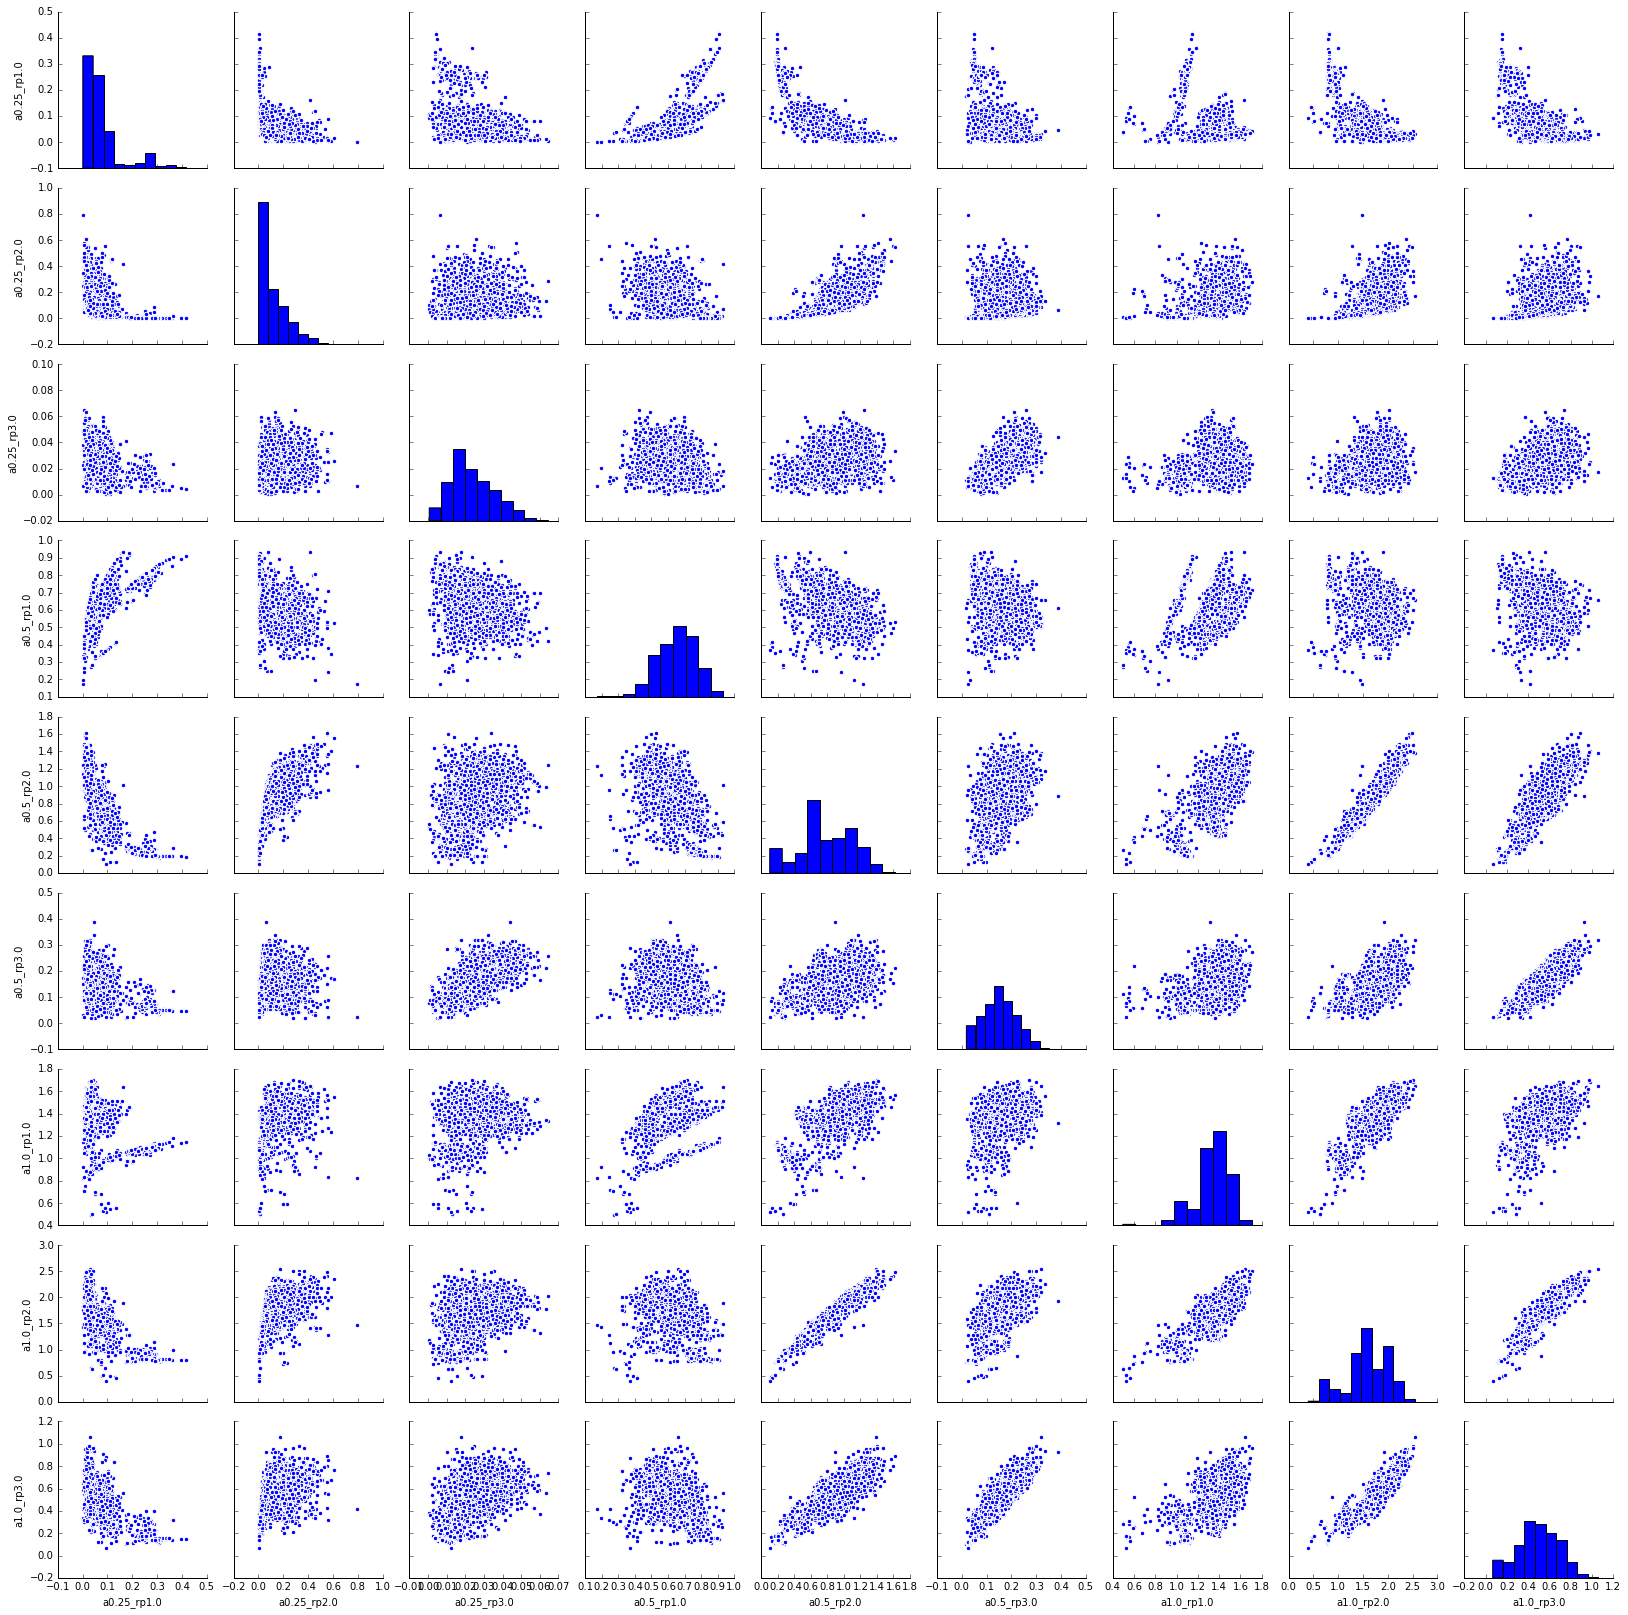

done


In [5]:
"""
4. visualization
"""
import seaborn
def plot_pair(df):
    """
    seaborn parplot of descriptors
    
    @param df : DataFrame
    """
    print("making pairplot")
    X = df.as_matrix().astype(np.float64)
    for x in X:
        for y in x:
            if not isinstance(y,np.float64):
                print (y)
    df2 = df.astype(np.float64)
    sns.pairplot(df2)
    plt.show()
    print("done")

plot_pair(df)